In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/narou
!ls -a
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/narou
 all_metadata.csv	    encoder_v2.pth	     ncodes_v2.npy
 ANIME			    ..GochiUsa_Dataset.pdf   .OFFICIAL_ILLUSTRATIONS.h5
 .ANIME.h5		    gochiuza_faces.zip_000   poolformer_for_P.pth
 ANIME.png		    gochiuza_faces.zip_001  'poolformer_only_body.ipynb '
 array_reduce.ipynb	    gochiuza_faces.zip_002   poolformer_only_body_v2.ipynb
 autoencoder.pth	    gochiuza_faces.zip_003   poolformer_only_head.ipynb
 bin_corpus_patch	    gochiuza_faces.zip_004   poolformer.pth
 bin_corpus_v1		    gochiuza_faces.zip_005   poolformer_v0.5.ipynb
 comformer_AE.ipynb	    gochiuza_faces.zip_006   poolformer_v0.ipynb
 comformer_large.ipynb	    gochiuza_faces.zip_007   poolformer_v1.ipynb
 corpus10_04		    gochiuza_faces.zip_008   poolformer_withlabel.pth
 corpus9_29		    gochiuza_faces.zip_009   predict_logCB.csv
 corpus_patch		    gochiuza_faces.zip_0

In [2]:
!pip install tqdm
from psutil import virtual_memory
import torch
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime
Sun Oct 22 16:29:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
         

In [3]:
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm
import math
import time

dataset

In [4]:
class FileDataset(torch.utils.data.Dataset):
    def __init__(self, corpus, df, max_length, buffer):
        self.corpus=corpus
        self.max_length=max_length
        self.ncodes = df["ncode"].to_numpy()
        self.buffer=buffer

    def __len__(self):
        return len(self.ncodes)

    def __getitem__(self, idx):
        torch.cuda.empty_cache()
        ncode=self.ncodes[idx]

        if self.buffer == None:
            seq=torch.load(f'{self.corpus}/{ncode}.pth')
            seq=seq[:self.max_length]
            time.sleep(0.1)
        else:
            seq=self.buffer[ncode]
        #label=self.labels[idx]
        return seq


In [5]:
from torch.nn.utils.rnn import pad_sequence
def My_collate_func(batch):
    xs= []
    for x in batch:
        xs.append(x)



    #データ長を揃える処理
    xs = pad_sequence(xs, batch_first=True)


    return xs

In [6]:
def manual_pad(x):
    batch_size, length, d = x.shape
    if length < 128:

        p=torch.zeros(batch_size, 128-length, d)
        x=torch.concat([x, p], dim = 1)
        print(f"padding to size:{x.shape}")
    else:
        pass
    return x

poolformer

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, dim, dropout = 0.0, max_len = 512*144//4+1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        position = torch.arange(max_len).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim)).to(device)
        pe = torch.zeros(max_len, 1, dim).to(device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        batch_size, max_len, dim = x.shape
        cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
        x = torch.concat([cls_tokens, x], dim = 1)
        pe=torch.transpose(self.pe[:max_len+1], 0,1)
        x = x + pe.repeat(batch_size, 1,1)
        return self.dropout(x)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, head_num, dropout = 0.0):
        super().__init__()
        self.dim = dim
        self.head_num = head_num
        self.linear_Q = nn.Linear(dim, dim, bias = False)
        self.linear_K = nn.Linear(dim, dim, bias = False)
        self.linear_V = nn.Linear(dim, dim, bias = False)
        self.linear = nn.Linear(dim, dim, bias = False)
        self.soft = nn.Softmax(dim = 3)
        self.dropout = nn.Dropout(dropout)
    def split_head(self, x):
        x = torch.tensor_split(x, self.head_num, dim = 2)
        x = torch.stack(x, dim = 1)
        return x
    def concat_head(self, x):
        x = torch.tensor_split(x, x.size()[1], dim = 1)
        x = torch.concat(x, dim = 3).squeeze(dim = 1)
        return x

    def forward(self, Q, K, V, mask = None):
        Q = self.linear_Q(Q)   #(BATCH_SIZE,word_count,dim)
        K = self.linear_K(K)
        V = self.linear_V(V)

        Q = self.split_head(Q)   #(BATCH_SIZE,head_num,word_count//head_num,dim)
        K = self.split_head(K)
        V = self.split_head(V)

        QK = torch.matmul(Q, torch.transpose(K, 3, 2))
        QK = QK/((self.dim//self.head_num)**0.5)

        if mask is not None:
        #print(f"QK:{np.shape(QK)}, mask:{np.shape(mask)}")
            QK = QK + mask

        softmax_QK = self.soft(QK)
        softmax_QK = self.dropout(softmax_QK)

        QKV = torch.matmul(softmax_QK, V)
        QKV = self.concat_head(QKV)
        QKV = self.linear(QKV)
        return QKV

class FeedForward(nn.Module):

    def __init__(self, dim, dropout = 0.0):
        super().__init__()
        hidden_dim=int(dim*2)
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(dim, hidden_dim)
        self.gelu = nn.GELU()
        self.linear_2 = nn.Linear(hidden_dim, dim)
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

class transblock(nn.Module):

    def __init__(self, dim, head_num, dropout = 0.0):
        super().__init__()
        self.MHA = MultiHeadAttention(dim, head_num)
        self.layer_norm_1 = nn.LayerNorm([dim])
        self.layer_norm_2 = nn.LayerNorm([dim])
        self.FF = FeedForward(dim)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x):
        Q = K = V = x
        x = self.layer_norm_1(x)
        x = self.MHA(Q, K, V)
        x = self.dropout_1(x)
        x = x + Q
        _x = x.clone()
        x = self.layer_norm_2(x)
        x = self.FF(x)
        x = self.dropout_2(x)
        x = x + _x
        return x


class transformer(nn.Module):
    def __init__(self, channel, layer=6, dropout = 0.0):
        super().__init__()
        self.pe=PositionalEncoding(channel)
        self.transformer = nn.Sequential(*[transblock(channel, channel//4) for _ in range(layer)])
    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x=self.pe(x)
        x=self.transformer(x)
        x = torch.transpose(x[:,1:], 1, 2)
        return x



class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernal_size=3, stride=1, reverse=False):
        super().__init__()

        self.shortcut=nn.Sequential(nn.Identity())

        if  in_channel != out_channel:
            self.shortcut.add_module("point", nn.Conv1d(in_channel, out_channel, 1, 1, padding=0))

        if reverse==False:
            self.conv2=nn.Conv1d(in_channel//2, in_channel//2, kernal_size, stride, groups=in_channel//2, padding=1)
            if stride != 1:
                self.shortcut.add_module("pool", nn.AvgPool1d(kernal_size, stride, padding=1))
        else:
            self.conv2=nn.ConvTranspose1d(in_channel//2, in_channel//2, kernal_size, stride, groups=in_channel//2, padding=1)
            if stride != 1:
                self.shortcut.add_module("convT", nn.ConvTranspose1d(out_channel, out_channel, kernal_size, stride, groups=out_channel, padding=1))
        self.conv1=nn.Conv1d(in_channel,in_channel//2, 1, 1, padding=0)
        self.conv3=nn.Conv1d(in_channel//2, out_channel, 1, 1,  padding=0)
        self.gelu=nn.GELU()
        self.norm1=nn.GroupNorm(1, in_channel)
        self.norm2=nn.GroupNorm(1, in_channel//2)


    def forward(self, x):
        _x=self.shortcut(x)

        x=self.norm1(x)
        x=self.gelu(x)
        x=self.conv1(x)
        x=self.norm2(x)
        x=self.gelu(x)
        x=self.conv2(x)
        x=self.conv3(x)+_x



        return x

class stage(nn.Module):
    def __init__(self, channel, kernal_size=3, stride=2):
        super().__init__()
        #self.skip=skip
        self.downsample=ConvBlock(channel, channel*2, kernal_size, stride=stride)
        self.upsample=ConvBlock(channel*2, channel, kernal_size, stride=stride, reverse=True)
        self.convblock1=nn.Sequential(*[ConvBlock(channel*2, channel*2, kernal_size=3) for _ in range(6)])
        self.convblock2=nn.Sequential(*[ConvBlock(channel*2, channel*2, kernal_size=3) for _ in range(6)])
        if channel >= 256:
            self.next_stage=transformer(channel*2)
        else:
            self.next_stage=stage(channel*2, kernal_size=3, stride=2)



    def forward(self, x):
        #if self.skip:
        #_x=x.clone()
        #N, C, W_ = _x.shape
        x=self.downsample(x)
        x=self.convblock1(x)
        x=self.next_stage(x)
        x=self.convblock2(x)
        x=self.upsample(x)
        N, C, W = x.shape

        #if self.skip:
        #if W_ > W:
        #    x =_x[:, :, :W ]+ x
        #else:
        #    x = x[:, :, :W_]+ _x






        return x



class autoencoder(nn.Module):
    def __init__(self, pretrain=True):
        super().__init__()
        self.down=ConvBlock(32, 32, 7, 4)
        self.up=ConvBlock(32, 32, 7, 4, reverse=True)
        self.maxpool=nn.MaxPool1d(3, 2)
        self.upsample=nn.ConvTranspose1d(32, 32, 3, 2, groups=32)
        self.stage=stage(32)
        self.linear=nn.Linear(32, 32)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)
        x=self.down(x)
        x=self.maxpool(x)
        x=self.stage(x)
        x=self.upsample(x)
        x=self.up(x)
        x = torch.transpose(x, 1, 2)
        #x=self.linear(x)

        return x

train

        ncode  Unnamed: 0  ncode.1  general_firstup  general_lastup  \
0     N3669FW           0  N3669FW       1574028356      1676821602   
1     N2710DB           1  N2710DB       1451957052      1676936678   
2     N9669BK           2  N9669BK       1353603634      1428102000   
3     N3976GK           3  N3976GK       1596493562      1618432760   
4     N0611EM           4  N0611EM       1514750300      1669501706   
...       ...         ...      ...              ...             ...   
5277  N8016FI        8187  N8016FI       1551623841      1616868017   
5278  N1866GK        8188  N1866GK       1596179602      1597567959   
5279  N0096BC        8189  N0096BC       1329972942      1339884000   
5280  N9623HP        8190  N9623HP       1652083202      1655449873   
5281  N3280BU        8191  N3280BU       1379499666      1406146646   

      novel_type    end  logH/B         P  biggenre_1  biggenre_2  biggenre_3  \
0          False   True     NaN  1.085201       False        True 

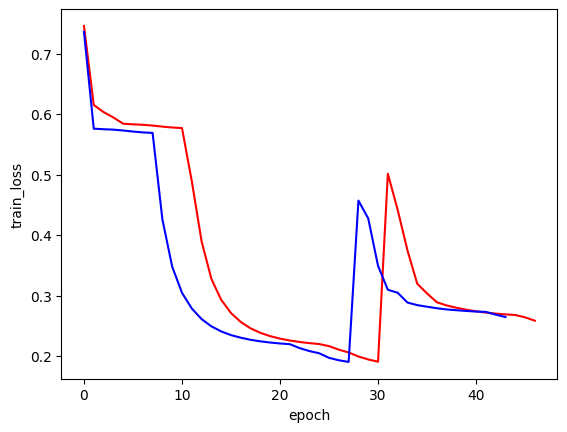

In [8]:

def train(device):
    max_length = 128*512
    batch_size = 1
    epochs = 32
    lr =  1e-5
    valid_rate = 0.05
    preload=False
    model = torch.load("autoencoder.pth").to(device)
    #model=autoencoder().to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    corpus = "bin_corpus_v1"
    csv = "HighPoint.csv"
    #df=pd.read_csv(csv)
    #df.set_index('ncode', inplace=True, drop=False)
    #print(len(set(df.index)))
    #for ncode in set(df.index):
    #    if os.path.isfile(f"{corpus}/{ncode}.pth"):
    #        pass
    #    else:
    #        df.drop(index=ncode, axis=0, inplace=True)

    if ram_gb >= 20 and preload==True:
        buffer={}
        #print(df["ncode"])
        for ncode in tqdm(df["ncode"]):
            seq=torch.load(f'{corpus}/{ncode}.pth')
            buffer[ncode]=seq[:max_length]
            time.sleep(0.1)
            del seq
    else:
        buffer=None

    vd=pd.read_csv("valid_data_ae.csv")
    df=pd.read_csv("data_ae.csv")
    #df=df.dropna(how="any")
    #vd=df.sample(int(len(df)*valid_rate))
    #vd.to_csv("valid_data_ae.csv", index=True)
    #df.drop(index=vd.index.to_list(), inplace=True)
    print(df)
    #df.to_csv("data_ae.csv", index=True)
    train_dataset = FileDataset(corpus, df, max_length, buffer)
    valid_dataset = FileDataset(corpus, vd, max_length, buffer)
    train_dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, drop_last=False, collate_fn=My_collate_func, num_workers=0)
    val_dataloader = torch.utils.data.DataLoader(valid_dataset,  batch_size=batch_size, shuffle=True, drop_last=False, collate_fn=My_collate_func, num_workers=0)



    try:
        with open("train_loss_log_ae", "r") as tl:
            train_loss_list=tl.read().split()

        train_loss_list=[float(n) for n in train_loss_list]
        with open("valid_loss_log_ae", "r") as vl:
            valid_loss_list=vl.read().split()
        valid_loss_list=[float(n) for n in valid_loss_list]
    except:
        train_loss_list=[]
        valid_loss_list=[]
    print(train_loss_list)
    print(valid_loss_list)
    for epoch in range(len(train_loss_list)+1,epochs+1):

        model.train()
        total_loss_train=0.0
        n=0
        batsu=0

        for seq in tqdm(train_dataloader):

            print(f"seq length:{seq.shape[1]//128}")
            if seq.shape[1] < 128:
                #seq=manual_pad(seq)
                continue
            #elif n > 6:
            #    break
            else:
                pass
            seq=seq.to(device)
            optimizer.zero_grad()
            output=model(seq)
            N, Li, D = seq.shape
            N, Lo, D = output.shape
            if Lo > Li:
                output=output[:,:Li,:]
            else:
                seq=seq[:,:Lo,:]

            loss=criterion(output, seq)
            loss.backward()
            total_loss_train+=loss.item()
            n += 1
            print(f'running loss:{loss.item():5.7}')
            optimizer.step()
            del seq, output, loss
            torch.cuda.empty_cache()
            !nvidia-smi --query-gpu=utilization.gpu --format=csv
            if n%1024==1:
                torch.save(model, "autoencoder.pth")
                print("saved")
        torch.save(model, "autoencoder.pth")


            #except Exception as e:
                #print(e)

        total_loss_train=total_loss_train/len(train_dataloader)
        scheduler.step()

        #valid
        model.eval()
        total_loss_valid=0.0
        with torch.no_grad():
            for seq in tqdm(val_dataloader):
                #try:
                if seq.shape[1] < 256:
                    #seq=manual_pad(seq)
                    continue
                #elif n > 10:
                #    break
                #else:
                #    pass
                    #optimizer.zero_grad()
                seq=seq.to(device)
                output=model(seq)
                N, Li, D = seq.shape
                N, Lo, D = output.shape
                if Lo > Li:
                    output=output[:,:Li,:]
                else:
                    seq=seq[:,:Lo,:]
                loss_valid=criterion(output, seq)
                total_loss_valid+=loss_valid.item()
                del seq, output, loss_valid
                #print(f'for patch No.{n}, running loss:{loss_valid.item():5.7}')
                torch.cuda.empty_cache()
                n += 1
                #except Exception as e:
                    #print(e)
        total_loss_valid=total_loss_valid/len(val_dataloader)



        train_loss_list.append(total_loss_train)
        valid_loss_list.append(total_loss_valid)
        with open("train_loss_log_ae", "w") as tl:
            tl.write('\n'.join([str(n) for n in train_loss_list]))
        with open("valid_loss_log_ae", "w") as vl:
            vl.write('\n'.join([str(n) for n in valid_loss_list]))
        print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')

        if total_loss_train < total_loss_valid:
            batsu+=1
        else:
            pass
        if  batsu > 3:
            print("early stop")
            #break


    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.plot(train_loss_list, color='r', label="train")
    plt.plot(valid_loss_list, color='b', label="valid")
    plt.show()



    return model

if __name__ == "__main__":
    train(device)